<a href="https://colab.research.google.com/github/akispan/author_recognition_from_articles/blob/main/authors_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
!ls

drive  sample_data


In [3]:
%matplotlib inline
import json
 
with open('/content/drive/My Drive/data_for_colab/paper/last_data2/train200.json') as f:
    train = json.load(f)
with open('/content/drive/My Drive/data_for_colab/paper/last_data2/dev200.json') as f:
    dev = json.load(f)
with open('/content/drive/My Drive/data_for_colab/paper/last_data2/test200.json') as f:
    test = json.load(f)

In [4]:
def delete_strange_authors(mytrain, mydev, mytest):
  removedWords = ['Του ','Της ','Των ','Υπεύθυνος: ','ΕΠΙΜΕΛΕΙΑ: ', 'Επιμέλεια: ','Από ', 'τον ', 'τη ', 'Με ','ΚΕΙΜΕΝΑ -  ','ΚΡΙΤΙΚΗ:  ','ΚΡΙΤΙΚΗ: ']
  mytrain = {k:v for k,v in mytrain.items() if ('@' not in k and '.' not in k)}
  mytrain = {k:v for k,v in sorted(mytrain.items())}
  mydev = {k:v for k,v in mydev.items() if ('@' not in k and '.' not in k)}
  mydev = {k:v for k,v in sorted(mydev.items())}
  mytest = {k:v for k,v in mytest.items() if ('@' not in k and '.' not in k)}
  mytest = {k:v for k,v in sorted(mytest.items())}
  newTrain = {}
  newDev   = {}
  newTest  = {}
  for item1, item2, item3 in zip(mytrain.items(), mydev.items(), mytest.items()):
    new = item1[0]
    for w in removedWords:
      if w in new:
        new = new.replace(w,'')
    if new not in newTrain.keys():
      newTrain.update({new:item1[1]})
      newDev.update({new:item2[1]})
      newTest.update({new:item3[1]})
  k = ['Θεσσαλονίκη','ΔΝΚ','Αθήνα','ΑΝΤΩΝΗ ΓΑΛΑΝΟΠΟΥΛΟΥ','ΝΙΝΟΣ ΦΕΝΕΚ  ΜΙΚΕΛΙΔΗΣ','ΛΗΔΑΣ ΠΑΠΑΔΟΠΟΥΛΟΥ','ΧΡΥΣΟΥΛΑΣ ΠΑΠΑΪΩΑΝΝΟΥ','Μγς','ΠΑΣ',' ΓΙΑΝΝΗΣ ΤΡΙΑΝΤΗΣ','ΜΑΝΤΑΙΟΣ']
  for item in k:
    if item in list(newTrain):
      del newTrain[item]
      del newDev[item]
      del newTest[item]

  return newTrain, newDev, newTest

def choose_size(train, dev, test, fraction, min_authors = 50):
  train_texts = int (160*fraction)
  dev_texts   = int (20*fraction)
  res1 = {}
  for key, values in train.items():
      res1.update({key: values[0:train_texts]})
  res2 = {}
  for key, values in dev.items():
      res2.update({key: values[0:dev_texts]})
  res3 = {}
  for key, values in test.items():
      res3.update({key: values[0:dev_texts]})
  train = dict(list(res1.items())[0:min_authors])
  dev = dict(list(res2.items())[0:min_authors])
  test = dict(list(res3.items())[0:min_authors])
  return train, dev, test

In [5]:
from collections import Counter
from pprint import pprint

def getVIA(mytrain):
  wordsPerText = Counter()
  for values in mytrain.values():
    for value in values:
      b = get_words(value)
      if len(b)>200:     #  use this for MLP
          b = b[0:200]
      wordsPerText.update(Counter(set(b)))
  wordsPerText = dict(wordsPerText)
  wordsPerText = {k:v for k,v in sorted(wordsPerText.items())}
  vocabulary = [x for x,y in wordsPerText.items() if y>5]
  vocabulary.insert(0,'PAD')
  idf = {x:(1.0/y) for x,y in wordsPerText.items() if y>5}
  authorsNames = [x for x in mytrain.keys()]
  return vocabulary, authorsNames, idf

In [6]:
from collections import defaultdict
from pprint import pprint
import re

# Functions for Text Manipulation

'''
stopwords = ['μη','εαυτου','αν','αλλ’','αλλα','αλλοσ','απο','αρα','αυτοσ','δ’','δε','δη','δια','δαι','δαισ','ετι', 'εγω','εκ','εμοσ','εν','επι','εἰ','εἰμι','ειμι','εἰσ','γαρ','γε','γα^','η','η','και','κατα','μεν','μετα','ο','οδε','οσ','οστισ','οτι','ουτωσ','ουτοσ','ουτε','ουν','ουδεισ','οἱ','ου','ουδε','ουκ','περι','προσ','συ','συν','τα','τε','την','τησ','τῇ','τι','τι','τισ','τισ','το','τοι','τοιουτοσ','τον','τουσ','του','τῶν','τῷ','ὑμοσ','ὑπερ','ὑπο','ὡσ','ὦ','ὥστε','εαν','παρα','σοσ','ο','η','το','οι','τα','του','τησ','των','τον','την','και','κι','κ','ειμαι','εισαι','ειναι','ειμαστε','ειστε','στο','στον','στη','στην','μα','αλλα','απο','για','προσ','με','σε','ωσ','παρα','αντι','κατα','μετα','θα','να','δε','δεν','μη','μην','επι','ενω','εαν','αν','τοτε','που','πωσ','ποιοσ','ποια','ποιο','ποιοι','ποιεσ','ποιων','ποιουσ','αυτοσ','αυτη','αυτο','αυτοι','αυτων','αυτουσ','αυτεσ','αυτα','εκεινοσ','εκεινη','εκεινο','εκεινοι','εκεινεσ','εκεινα','εκεινων','εκεινουσ','οπωσ','ομωσ','ισωσ','οσο','οτι','Α∆ΙΑΚΟΠΑ', 'ΑΙ', 'ΑΚΟΜΑ', 'ΑΚΟΜΗ', 'ΑΚΡΙΒΩΣ', 'ΑΛΗΘΕΙΑ', 'ΑΛΗΘΙΝΑ', 'ΑΛΛΑ', 'ΑΛΛΑΧΟΥ', 'ΑΛΛΕΣ', 'ΑΛΛΗ', 'ΑΛΛΗΝ', 'ΑΛΛΗΣ', 'ΑΛΛΙΩΣ', 'ΑΛΛΙΩΤΙΚΑ', 'ΑΛΛΟ', 'ΑΛΛΟΙ', 'ΑΛΛΟΙΩΣ', 'ΑΛΛΟΙΩΤΙΚΑ', 'ΑΛΛΟΝ', 'ΑΛΛΟΣ', 'ΑΛΛΟΤΕ', 'ΑΛΛΟΥ', 'ΑΛΛΟΥΣ', 'ΑΛΛΩΝ', 'ΑΜΑ', 'ΑΜΕΣΑ', 'ΑΜΕΣΩΣ', 'ΑΝ', 'ΑΝΑ', 'ΑΝΑΜΕΣΑ', 'ΑΝΑΜΕΤΑΞΥ', 'ΑΝΕΥ', 'ΑΝΤΙ', 'ΑΝΤΙΠΕΡΑ', 'ΑΝΤΙΣ', 'ΑΝΩ', 'ΑΝΩΤΕΡΩ', 'ΑΞΑΦΝΑ', 'ΑΠ', 'ΑΠΕΝΑΝΤΙ', 'ΑΠΟ', 'ΑΠΟΨΕ', 'ΑΡΑ', 'ΑΡΑΓΕ', 'ΑΡΓΑ', 'ΑΡΓΟΤΕΡΟ', 'ΑΡΙΣΤΕΡΑ', 'ΑΡΚΕΤΑ', 'ΑΡΧΙΚΑ', 'ΑΣ', 'ΑΥΡΙΟ', 'ΑΥΤΑ', 'ΑΥΤΕΣ', 'ΑΥΤΗ', 'ΑΥΤΗΝ', 'ΑΥΤΗΣ', 'ΑΥΤΟ', 'ΑΥΤΟΙ', 'ΑΥΤΟΝ', 'ΑΥΤΟΣ', 'ΑΥΤΟΥ', 'ΑΥΤΟΥΣ', 'ΑΥΤΩΝ', 'ΑΦΟΤΟΥ', 'ΑΦΟΥ', 'ΒΕΒΑΙΑ', 'ΒΕΒΑΙΟΤΑΤΑ', 'ΓΙ', 'ΓΙΑ', 'ΓΡΗΓΟΡΑ', 'ΓΥΡΩ', '∆Α', '∆Ε', '∆ΕΙΝΑ', '∆ΕΝ', '∆ΕΞΙΑ', '∆ΗΘΕΝ', '∆ΗΛΑ∆Η', '∆Ι', '∆ΙΑ', '∆ΙΑΡΚΩΣ', '∆ΙΚΑ', '∆ΙΚΟ', '∆ΙΚΟΙ', '∆ΙΚΟΣ', '∆ΙΚΟΥ', '∆ΙΚΟΥΣ', '∆ΙΟΛΟΥ', '∆ΙΠΛΑ', '∆ΙΧΩΣ', 'ΕΑΝ', 'ΕΑΥΤΟ', 'ΕΑΥΤΟΝ', 'ΕΑΥΤΟΥ', 'ΕΑΥΤΟΥΣ', 'ΕΑΥΤΩΝ', 'ΕΓΚΑΙΡΑ', 'ΕΓΚΑΙΡΩΣ', 'ΕΓΩ', 'Ε∆Ω', 'ΕΙ∆ΕΜΗ', 'ΕΙΘΕ', 'ΕΙΜΑΙ', 'ΕΙΜΑΣΤΕ', 'ΕΙΝΑΙ', 'ΕΙΣ', 'ΕΙΣΑΙ', 'ΕΙΣΑΣΤΕ', 'ΕΙΣΤΕ', 'ΕΙΤΕ', 'ΕΙΧΑ', 'ΕΙΧΑΜΕ', 'ΕΙΧΑΝ', 'ΕΙΧΑΤΕ', 'ΕΙΧΕ', 'ΕΙΧΕΣ', 'ΕΚΑΣΤΑ', 'ΕΚΑΣΤΕΣ', 'ΕΚΑΣΤΗ', 'ΕΚΑΣΤΗΝ', 'ΕΚΑΣΤΗΣ', 'ΕΚΑΣΤΟ', 'ΕΚΑΣΤΟΙ', 'ΕΚΑΣΤΟΝ', 'ΕΚΑΣΤΟΣ', 'ΕΚΑΣΤΟΥ', 'ΕΚΑΣΤΟΥΣ', 'ΕΚΑΣΤΩΝ', 'ΕΚΕΙ', 'ΕΚΕΙΝΑ', 'ΕΚΕΙΝΕΣ', 'ΕΚΕΙΝΗ', 'ΕΚΕΙΝΗΝ', 'ΕΚΕΙΝΗΣ', 'ΕΚΕΙΝΟ', 'ΕΚΕΙΝΟΙ', 'ΕΚΕΙΝΟΝ', 'ΕΚΕΙΝΟΣ', 'ΕΚΕΙΝΟΥ', 'ΕΚΕΙΝΟΥΣ', 'ΕΚΕΙΝΩΝ', 'ΕΚΤΟΣ', 'ΕΜΑΣ', 'ΕΜΕΙΣ', 'ΕΜΕΝΑ', 'ΕΜΠΡΟΣ', 'ΕΝ', 'ΕΝΑ', 'ΕΝΑΝ', 'ΕΝΑΣ', 'ΕΝΟΣ', 'ΕΝΤΕΛΩΣ', 'ΕΝΤΟΣ', 'ΕΝΤΩΜΕΤΑΞΥ', 'ΕΝΩ', 'ΕΞ', 'ΕΞΑΦΝΑ', 'ΕΞΗΣ', 'ΕΞΙΣΟΥ', 'ΕΞΩ', 'ΕΠΑΝΩ', 'ΕΠΕΙ∆Η', 'ΕΠΕΙΤΑ', 'ΕΠΙ', 'ΕΠΙΣΗΣ', 'ΕΠΟΜΕΝΩΣ', 'ΕΣΑΣ', 'ΕΣΕΙΣ', 'ΕΣΕΝΑ', 'ΕΣΤΩ', 'ΕΣΥ', 'ΕΤΕΡΑ', 'ΕΤΕΡΑΙ', 'ΕΤΕΡΑΣ', 'ΕΤΕΡΕΣ', 'ΕΤΕΡΗ', 'ΕΤΕΡΗΣ', 'ΕΤΕΡΟ', 'ΕΤΕΡΟΙ', 'ΕΤΕΡΟΝ', 'ΕΤΕΡΟΣ', 'ΕΤΕΡΟΥ', 'ΕΤΕΡΟΥΣ', 'ΕΤΕΡΩΝ', 'ΕΤΟΥΤΑ', 'ΕΤΟΥΤΕΣ', 'ΕΤΟΥΤΗ', 'ΕΤΟΥΤΗΝ', 'ΕΤΟΥΤΗΣ', 'ΕΤΟΥΤΟ', 'ΕΤΟΥΤΟΙ', 'ΕΤΟΥΤΟΝ', 'ΕΤΟΥΤΟΣ', 'ΕΤΟΥΤΟΥ', 'ΕΤΟΥΤΟΥΣ', 'ΕΤΟΥΤΩΝ', 'ΕΤΣΙ', 'ΕΥΓΕ', 'ΕΥΘΥΣ', 'ΕΥΤΥΧΩΣ', 'ΕΦΕΞΗΣ', 'ΕΧΕΙ', 'ΕΧΕΙΣ', 'ΕΧΕΤΕ', 'ΕΧΘΕΣ', 'ΕΧΟΜΕ', 'ΕΧΟΥΜΕ', 'ΕΧΟΥΝ', 'ΕΧΤΕΣ', 'ΕΧΩ', 'ΕΩΣ', 'Η', 'Η∆Η', 'ΗΜΑΣΤΑΝ', 'ΗΜΑΣΤΕ', 'ΗΜΟΥΝ', 'ΗΣΑΣΤΑΝ', 'ΗΣΑΣΤΕ', 'ΗΣΟΥΝ', 'ΗΤΑΝ', 'ΗΤΑΝΕ', 'ΗΤΟΙ', 'ΗΤΤΟΝ', 'ΘΑ', 'Ι', 'Ι∆ΙΑ', 'Ι∆ΙΑΝ', 'Ι∆ΙΑΣ', 'Ι∆ΙΕΣ', 'Ι∆ΙΟ', 'Ι∆ΙΟΙ', 'Ι∆ΙΟΝ', 'Ι∆ΙΟΣ', 'Ι∆ΙΟΥ', 'Ι∆ΙΟΥΣ', 'Ι∆ΙΩΝ', 'Ι∆ΙΩΣ', 'ΙΙ', 'ΙΙΙ', 'ΙΣΑΜΕ', 'ΙΣΙΑ', 'ΙΣΩΣ', 'ΚΑΘΕ', 'ΚΑΘΕΜΙΑ', 'ΚΑΘΕΜΙΑΣ', 'ΚΑΘΕΝΑ', 'ΚΑΘΕΝΑΣ', 'ΚΑΘΕΝΟΣ', 'ΚΑΘΕΤΙ', 'ΚΑΘΟΛΟΥ', 'ΚΑΘΩΣ', 'ΚΑΙ', 'ΚΑΚΑ', 'ΚΑΚΩΣ', 'ΚΑΛΑ', 'ΚΑΛΩΣ', 'ΚΑΜΙΑ', 'ΚΑΜΙΑΝ', 'ΚΑΜΙΑΣ', 'ΚΑΜΠΟΣΑ', 'ΚΑΜΠΟΣΕΣ', 'ΚΑΜΠΟΣΗ', 'ΚΑΜΠΟΣΗΝ', 'ΚΑΜΠΟΣΗΣ', 'ΚΑΜΠΟΣΟ', 'ΚΑΜΠΟΣΟΙ', 'ΚΑΜΠΟΣΟΝ', 'ΚΑΜΠΟΣΟΣ', 'ΚΑΜΠΟΣΟΥ', 'ΚΑΜΠΟΣΟΥΣ', 'ΚΑΜΠΟΣΩΝ', 'ΚΑΝΕΙΣ', 'ΚΑΝΕΝ', 'ΚΑΝΕΝΑ', 'ΚΑΝΕΝΑΝ', 'ΚΑΝΕΝΑΣ', 'ΚΑΝΕΝΟΣ', 'ΚΑΠΟΙΑ', 'ΚΑΠΟΙΑΝ', 'ΚΑΠΟΙΑΣ', 'ΚΑΠΟΙΕΣ', 'ΚΑΠΟΙΟ', 'ΚΑΠΟΙΟΙ', 'ΚΑΠΟΙΟΝ', 'ΚΑΠΟΙΟΣ', 'ΚΑΠΟΙΟΥ', 'ΚΑΠΟΙΟΥΣ', 'ΚΑΠΟΙΩΝ', 'ΚΑΠΟΤΕ', 'ΚΑΠΟΥ', 'ΚΑΠΩΣ', 'ΚΑΤ', 'ΚΑΤΑ', 'ΚΑΤΙ', 'ΚΑΤΙΤΙ', 'ΚΑΤΟΠΙΝ', 'ΚΑΤΩ', 'ΚΙΟΛΑΣ', 'ΚΛΠ', 'ΚΟΝΤΑ', 'ΚΤΛ', 'ΚΥΡΙΩΣ', 'ΛΙΓΑΚΙ', 'ΛΙΓΟ', 'ΛΙΓΩΤΕΡΟ', 'ΛΟΓΩ', 'ΛΟΙΠΑ', 'ΛΟΙΠΟΝ', 'ΜΑ', 'ΜΑΖΙ', 'ΜΑΚΑΡΙ', 'ΜΑΚΡΥΑ', 'ΜΑΛΙΣΤΑ', 'ΜΑΛΛΟΝ', 'ΜΑΣ', 'ΜΕ', 'ΜΕΘΑΥΡΙΟ', 'ΜΕΙΟΝ', 'ΜΕΛΕΙ', 'ΜΕΛΛΕΤΑΙ', 'ΜΕΜΙΑΣ', 'ΜΕΝ', 'ΜΕΡΙΚΑ', 'ΜΕΡΙΚΕΣ', 'ΜΕΡΙΚΟΙ', 'ΜΕΡΙΚΟΥΣ', 'ΜΕΡΙΚΩΝ', 'ΜΕΣΑ', 'ΜΕΤ', 'ΜΕΤΑ', 'ΜΕΤΑΞΥ', 'ΜΕΧΡΙ', 'ΜΗ', 'ΜΗ∆Ε', 'ΜΗΝ', 'ΜΗΠΩΣ', 'ΜΗΤΕ', 'ΜΙΑ', 'ΜΙΑΝ', 'ΜΙΑΣ', 'ΜΟΛΙΣ', 'ΜΟΛΟΝΟΤΙ', 'ΜΟΝΑΧΑ', 'ΜΟΝΕΣ', 'ΜΟΝΗ', 'ΜΟΝΗΝ', 'ΜΟΝΗΣ', 'ΜΟΝΟ', 'ΜΟΝΟΙ', 'ΜΟΝΟΜΙΑΣ', 'ΜΟΝΟΣ', 'ΜΟΝΟΥ', 'ΜΟΝΟΥΣ', 'ΜΟΝΩΝ', 'ΜΟΥ', 'ΜΠΟΡΕΙ', 'ΜΠΟΡΟΥΝ', 'ΜΠΡΑΒΟ', 'ΜΠΡΟΣ', 'ΝΑ', 'ΝΑΙ', 'ΝΩΡΙΣ', 'ΞΑΝΑ', 'ΞΑΦΝΙΚΑ', 'Ο', 'ΟΙ', 'ΟΛΑ', 'ΟΛΕΣ', 'ΟΛΗ', 'ΟΛΗΝ', 'ΟΛΗΣ', 'ΟΛΟ', 'ΟΛΟΓΥΡΑ', 'ΟΛΟΙ', 'ΟΛΟΝ', 'ΟΛΟΝΕΝ', 'ΟΛΟΣ', 'ΟΛΟΤΕΛΑ', 'ΟΛΟΥ', 'ΟΛΟΥΣ', 'ΟΛΩΝ', 'ΟΛΩΣ', 'ΟΛΩΣ∆ΙΟΛΟΥ', 'ΟΜΩΣ', 'ΟΠΟΙΑ', 'ΟΠΟΙΑ∆ΗΠΟΤΕ', 'ΟΠΟΙΑΝ', 'ΟΠΟΙΑΝ∆ΗΠΟΤΕ', 'ΟΠΟΙΑΣ', 'ΟΠΟΙΑΣ∆ΗΠΟΤΕ', 'ΟΠΟΙ∆ΗΠΟΤΕ', 'ΟΠΟΙΕΣ', 'ΟΠΟΙΕΣ∆ΗΠΟΤΕ', 'ΟΠΟΙΟ', 'ΟΠΟΙΟ∆ΗΠΟΤΕ', 'ΟΠΟΙΟΙ', 'ΟΠΟΙΟΝ', 'ΟΠΟΙΟΝ∆ΗΠΟΤΕ', 'ΟΠΟΙΟΣ', 'ΟΠΟΙΟΣ∆ΗΠΟΤΕ', 'ΟΠΟΙΟΥ', 'ΟΠΟΙΟΥ∆ΗΠΟΤΕ', 'ΟΠΟΙΟΥΣ', 'ΟΠΟΙΟΥΣ∆ΗΠΟΤΕ', 'ΟΠΟΙΩΝ', 'ΟΠΟΙΩΝ∆ΗΠΟΤΕ', 'ΟΠΟΤΕ', 'ΟΠΟΤΕ∆ΗΠΟΤΕ', 'ΟΠΟΥ', 'ΟΠΟΥ∆ΗΠΟΤΕ', 'ΟΠΩΣ', 'ΟΡΙΣΜΕΝΑ', 'ΟΡΙΣΜΕΝΕΣ', 'ΟΡΙΣΜΕΝΩΝ', 'ΟΡΙΣΜΕΝΩΣ', 'ΟΣΑ', 'ΟΣΑ∆ΗΠΟΤΕ', 'ΟΣΕΣ', 'ΟΣΕΣ∆ΗΠΟΤΕ', 'ΟΣΗ', 'ΟΣΗ∆ΗΠΟΤΕ', 'ΟΣΗΝ', 'ΟΣΗΝ∆ΗΠΟΤΕ', 'ΟΣΗΣ', 'ΟΣΗΣ∆ΗΠΟΤΕ', 'ΟΣΟ', 'ΟΣΟ∆ΗΠΟΤΕ', 'ΟΣΟΙ', 'ΟΣΟΙ∆ΗΠΟΤΕ', 'ΟΣΟΝ', 'ΟΣΟΝ∆ΗΠΟΤΕ', 'ΟΣΟΣ', 'ΟΣΟΣ∆ΗΠΟΤΕ', 'ΟΣΟΥ', 'ΟΣΟΥ∆ΗΠΟΤΕ', 'ΟΣΟΥΣ', 'ΟΣΟΥΣ∆ΗΠΟΤΕ', 'ΟΣΩΝ', 'ΟΣΩΝ∆ΗΠΟΤΕ', 'ΟΤΑΝ', 'ΟΤΙ', 'ΟΤΙ∆ΗΠΟΤΕ', 'ΟΤΟΥ', 'ΟΥ', 'ΟΥ∆Ε', 'ΟΥΤΕ', 'ΟΧΙ', 'ΠΑΛΙ', 'ΠΑΝΤΟΤΕ', 'ΠΑΝΤΟΥ', 'ΠΑΝΤΩΣ', 'ΠΑΡΑ', 'ΠΕΡΑ', 'ΠΕΡΙ', 'ΠΕΡΙΠΟΥ', 'ΠΕΡΙΣΣΟΤΕΡΟ', 'ΠΕΡΣΙ', 'ΠΕΡΥΣΙ', 'ΠΙΑ', 'ΠΙΘΑΝΟΝ', 'ΠΙΟ', 'ΠΙΣΩ', 'ΠΛΑΙ', 'ΠΛΕΟΝ', 'ΠΛΗΝ', 'ΠΟΙΑ', 'ΠΟΙΑΝ', 'ΠΟΙΑΣ', 'ΠΟΙΕΣ', 'ΠΟΙΟ', 'ΠΟΙΟΙ', 'ΠΟΙΟΝ', 'ΠΟΙΟΣ', 'ΠΟΙΟΥ', 'ΠΟΙΟΥΣ', 'ΠΟΙΩΝ', 'ΠΟΛΥ', 'ΠΟΣΕΣ', 'ΠΟΣΗ', 'ΠΟΣΗΝ', 'ΠΟΣΗΣ', 'ΠΟΣΟΙ', 'ΠΟΣΟΣ', 'ΠΟΣΟΥΣ', 'ΠΟΤΕ', 'ΠΟΥ', 'ΠΟΥΘΕ', 'ΠΟΥΘΕΝΑ', 'ΠΡΕΠΕΙ', 'ΠΡΙΝ', 'ΠΡΟ', 'ΠΡΟΚΕΙΜΕΝΟΥ', 'ΠΡΟΚΕΙΤΑΙ', 'ΠΡΟΠΕΡΣΙ', 'ΠΡΟΣ', 'ΠΡΟΤΟΥ', 'ΠΡΟΧΘΕΣ', 'ΠΡΟΧΤΕΣ', 'ΠΡΩΤΥΤΕΡΑ', 'ΠΩΣ', 'ΣΑΝ', 'ΣΑΣ', 'ΣΕ', 'ΣΕΙΣ', 'ΣΗΜΕΡΑ', 'ΣΙΓΑ', 'ΣΟΥ', 'ΣΤΑ', 'ΣΤΗ', 'ΣΤΗΝ', 'ΣΤΗΣ', 'ΣΤΙΣ', 'ΣΤΟ', 'ΣΤΟΝ', 'ΣΤΟΥ', 'ΣΤΟΥΣ', 'ΣΤΩΝ', 'ΣΥΓΧΡΟΝΩΣ', 'ΣΥΝ', 'ΣΥΝΑΜΑ', 'ΣΥΝΕΠΩΣ', 'ΣΥΝΗΘΩΣ', 'ΣΥΧΝΑ', 'ΣΥΧΝΑΣ', 'ΣΥΧΝΕΣ', 'ΣΥΧΝΗ', 'ΣΥΧΝΗΝ', 'ΣΥΧΝΗΣ', 'ΣΥΧΝΟ', 'ΣΥΧΝΟΙ', 'ΣΥΧΝΟΝ', 'ΣΥΧΝΟΣ', 'ΣΥΧΝΟΥ', 'ΣΥΧΝΟΥ', 'ΣΥΧΝΟΥΣ', 'ΣΥΧΝΩΝ', 'ΣΥΧΝΩΣ', 'ΣΧΕ∆ΟΝ', 'ΣΩΣΤΑ', 'ΤΑ', 'ΤΑ∆Ε', 'ΤΑΥΤΑ', 'ΤΑΥΤΕΣ', 'ΤΑΥΤΗ', 'ΤΑΥΤΗΝ', 'ΤΑΥΤΗΣ', 'ΤΑΥΤΟ', 'ΤΑΥΤΟΝ', 'ΤΑΥΤΟΣ', 'ΤΑΥΤΟΥ', 'ΤΑΥΤΩΝ', 'ΤΑΧΑ', 'ΤΑΧΑΤΕ', 'ΤΕΛΙΚΑ', 'ΤΕΛΙΚΩΣ', 'ΤΕΣ', 'ΤΕΤΟΙΑ', 'ΤΕΤΟΙΑΝ', 'ΤΕΤΟΙΑΣ', 'ΤΕΤΟΙΕΣ', 'ΤΕΤΟΙΟ', 'ΤΕΤΟΙΟΙ', 'ΤΕΤΟΙΟΝ', 'ΤΕΤΟΙΟΣ', 'ΤΕΤΟΙΟΥ', 'ΤΕΤΟΙΟΥΣ', 'ΤΕΤΟΙΩΝ', 'ΤΗ', 'ΤΗΝ', 'ΤΗΣ', 'ΤΙ', 'ΤΙΠΟΤΑ', 'ΤΙΠΟΤΕ', 'ΤΙΣ', 'ΤΟ', 'ΤΟΙ', 'ΤΟΝ', 'ΤΟΣ', 'ΤΟΣΑ', 'ΤΟΣΕΣ', 'ΤΟΣΗ', 'ΤΟΣΗΝ', 'ΤΟΣΗΣ', 'ΤΟΣΟ', 'ΤΟΣΟΙ', 'ΤΟΣΟΝ', 'ΤΟΣΟΣ', 'ΤΟΣΟΥ', 'ΤΟΣΟΥΣ', 'ΤΟΣΩΝ', 'ΤΟΤΕ', 'ΤΟΥ', 'ΤΟΥΛΑΧΙΣΤΟ', 'ΤΟΥΛΑΧΙΣΤΟΝ', 'ΤΟΥΣ', 'ΤΟΥΤΑ', 'ΤΟΥΤΕΣ', 'ΤΟΥΤΗ', 'ΤΟΥΤΗΝ', 'ΤΟΥΤΗΣ', 'ΤΟΥΤΟ', 'ΤΟΥΤΟΙ', 'ΤΟΥΤΟΙΣ', 'ΤΟΥΤΟΝ', 'ΤΟΥΤΟΣ', 'ΤΟΥΤΟΥ', 'ΤΟΥΤΟΥΣ', 'ΤΟΥΤΩΝ', 'ΤΥΧΟΝ', 'ΤΩΝ', 'ΤΩΡΑ', 'ΥΠ', 'ΥΠΕΡ', 'ΥΠΟ', 'ΥΠΟΨΗ', 'ΥΠΟΨΙΝ', 'ΥΣΤΕΡΑ', 'ΦΕΤΟΣ', 'ΧΑΜΗΛΑ', 'ΧΘΕΣ', 'ΧΤΕΣ', 'ΧΩΡΙΣ', 'ΧΩΡΙΣΤΑ', 'ΨΗΛΑ', 'Ω', 'ΩΡΑΙΑ', 'ΩΣ', 'ΩΣΑΝ', 'ΩΣΟΤΟΥ', 'ΩΣΠΟΥ', 'ΩΣΤΕ', 'ΩΣΤΟΣΟ', 'ΩΧ', 'απ', 'απο', 'γι', 'για', 'δι', 'δια', 'εις', 'εκ', 'ενα', 'εναν', 'ενας', 'ενος', 'εξ', 'επ', 'επι', 'καθ', 'και', 'κατ', 'κατα', 'με', 'μεσα', 'μια', 'μια', 'μια', 'μιαν', 'μιας', 'περι', 'σε', 'στα', 'στη', 'στην', 'στις', 'στο', 'στον', 'στους', 'τα', 'τη', 'την', 'της', 'τις', 'το', 'τον', 'του', 'τους', 'των', 'υπο']
stopwords2 = []
for word in stopwords:
  stopwords2.append(word.lower())
len(stopwords2)
'''

def replace_all(text):
  dic = {'ά': 'α', 'έ': 'ε', 'ί': 'ι', 'ϊ': 'ι', 'ΐ': 'ι', 'ή': 'η', 'ύ': 'υ', 'ϋ': 'υ', 'ΰ': 'υ', 'ώ': 'ω', 'ό': 'ο'}
  for i, j in dic.items():
    text = text.replace(i, j)
  return text

def get_words(s):
  w = s.lower()
  w = replace_all(w)
  w = re.sub('[^A-Za-zΑ-Ωα-ω]+', ' ', w)
  w = w.split()
  # w = [word for word in w if (any(i.isdigit() for i in word) == False) and (word not in stopwords2)]
  w = [word for word in w if (any(i.isdigit() for i in word) == False)]
  return w

def create_input(text, vocabulary, max_length=200):
  b           = get_words(text)
  input_row   = [vocabulary.index(word) for word in b if (word in vocabulary)][:max_length]
  pad_with    = [0]*(max_length-len(input_row))
  input_row   = pad_with + input_row
  return input_row

In [7]:
train, dev, test = delete_strange_authors(train, dev, test)
train, dev, test = choose_size(train, dev, test, fraction = 4/4)
vocabulary, authorsNames, idf = getVIA(train)

In [8]:
print('len of vocabulary  : ',len(vocabulary))
print('len of authorsNames: ',len(authorsNames))
print('len of idf         : ',len(idf))

len of vocabulary  :  19953
len of authorsNames:  50
len of idf         :  19952


In [9]:
from collections import defaultdict

def get_tf(words):
  tf = defaultdict(int)
  for word in words:
    tf[word] += 1
  tf = {x:(y/len(words)) for x,y in tf.items()}
  return tf

In [10]:
def unique(list1): 
  unique_list = [] 
  for x in list1: 
    if x not in unique_list: 
      unique_list.append(x) 
  return unique_list

def separate_dict_to_texts_and_author_lists(myset):
  texts = []
  authors = []
  for key, values in myset.items():
    for value in values:
      texts.append(value)
      authors.append(key)
  return texts, authors

texts, authors = separate_dict_to_texts_and_author_lists(train)
texts2, authors2 = separate_dict_to_texts_and_author_lists(dev)

In [ ]:
'''
import numpy as np
import random
import os
import re

def batch(indexes, authorsNames, vocabulary, idf, myset, target, n=1):
  max_length = 200
  ########################################
  for ndx in range(0, len(indexes), n):
  ########################################
    input = []
    output = []
    for i in indexes[ndx: ndx + n]:
      text, name = myset[i], target[i]
      input_row = [0] * len(vocabulary)
      b = get_words(text)
      # input_row   = [vocabulary.index(word) for word in b if (word in vocabulary)][:max_length]
      # pad_with    = [0]*(max_length-len(input_row))
      # input_row   = pad_with + input_row
      b1 = list(Counter(b))
      # b1 = list(Counter(set(b)))
      if len(b1)>200:
        b1 = b1[0:200]
      # tf = get_tf(b1)
      for word in b1:
        if (word in idf) and (idf[word] != 1):
          j = vocabulary.index(word)
          input_row[j] = idf[word]
          # input_row[j] = idf[word]*tf[word]
      ########################################
      input.append(input_row)
      output.append(authorsNames.index(name))
    yield (np.array(input), np.array(output))
'''

'\nimport numpy as np\nimport random\nimport os\nimport re\n\ndef batch(indexes, authorsNames, vocabulary, idf, myset, target, n=1):\n  max_length = 200\n  ########################################\n  for ndx in range(0, len(indexes), n):\n  ########################################\n    input = []\n    output = []\n    for i in indexes[ndx: ndx + n]:\n      text, name = myset[i], target[i]\n      input_row = [0] * len(vocabulary)\n      b = get_words(text)\n      # input_row   = [vocabulary.index(word) for word in b if (word in vocabulary)][:max_length]\n      # pad_with    = [0]*(max_length-len(input_row))\n      # input_row   = pad_with + input_row\n      b1 = list(Counter(b))\n      # b1 = list(Counter(set(b)))\n      if len(b1)>200:\n        b1 = b1[0:200]\n      # tf = get_tf(b1)\n      for word in b1:\n        if (word in idf) and (idf[word] != 1):\n          j = vocabulary.index(word)\n          input_row[j] = idf[word]\n          # input_row[j] = idf[word]*tf[word]\n      ######

In [ ]:
'''
#############################################
#                                           #
#        BACHERATOR FOR MLP_EMB & RNN       #
#                                           #
#############################################

import numpy as np
import random
import os
import re


def batch(indexes, authorsNames, vocabulary, idf, myset, target, n=1):
  ########################################
  max_length = 200
  for ndx in range(0, len(indexes), n):
  ########################################
    input = []
    output = []
    for i in indexes[ndx: ndx + n]:
      text, name  = myset[i], target[i]
      b           = get_words(text)
      # b1          = list(Counter(b))
      input_row   = [vocabulary.index(word) for word in b if (word in vocabulary)][:max_length]
      pad_with    = [0]*(max_length-len(input_row))
      input_row   = pad_with + input_row
      # if len(b1)>max_length:
      #   b1 = b1[0:max_length]
      # else:
      #   b1 = ['PAD']*(max_length-len(b1)) + b1
      # input_row = []
      # for word in b1:
      #   if (word in vocabulary):
      #     j = vocabulary.index(word)
      #     input_row.append(j)
      # if len(input_row)<max_length:
      #   input_row.extend([0]*(max_length-len(input_row)))
      ########################################
      input.append(input_row)
      output.append(authorsNames.index(name))
    # yield (np.array(input), np.array(output))
    yield input, output
'''

"\n#############################################\n#                                           #\n#        BACHERATOR FOR MLP_EMB & RNN       #\n#                                           #\n#############################################\n\nimport numpy as np\nimport random\nimport os\nimport re\n\n\ndef batch(indexes, authorsNames, vocabulary, idf, myset, target, n=1):\n  ########################################\n  max_length = 200\n  for ndx in range(0, len(indexes), n):\n  ########################################\n    input = []\n    output = []\n    for i in indexes[ndx: ndx + n]:\n      text, name  = myset[i], target[i]\n      b           = get_words(text)\n      # b1          = list(Counter(b))\n      input_row   = [vocabulary.index(word) for word in b if (word in vocabulary)][:max_length]\n      pad_with    = [0]*(max_length-len(input_row))\n      input_row   = pad_with + input_row\n      # if len(b1)>max_length:\n      #   b1 = b1[0:max_length]\n      # else:\n      #   b1 = ['P

In [11]:
#############################################
#                                           #
#        BACHERATOR FOR MLP_EMB & RNN       #
#                                           #
#############################################

import numpy as np
import random
import os
import re


def batch(indexes, authorsNames, vocabulary, idf, myset, target, n=1):
  max_length = 200
  for ndx in range(0, len(indexes), n):
    input = []
    output = []
    for i in indexes[ndx: ndx + n]:
      text, name  = myset[i], target[i]
      input_row   = create_input(text, vocabulary)
      input.append(input_row)
      output.append(authorsNames.index(name))
    yield input, output

In [12]:
# creates scores from models y,  noTexts x len(vocabulary) 
def get_y_scores(pred):
  y_scores = []
  for items in pred:
    for item in list(items.cpu().data.numpy()):
      y_scores.append(list(item))
  return y_scores

# creates authors noTexts x len(authors) with 0 and 1 from list with authors indexes
def get_y_true(y_true_index_of_author):
  y_true = []
  for item in y_true_index_of_author:
    row = [0] * len(authorsNames)
    row[item] = 1
    y_true.append(row)
  return y_true

##### roc_auc_score takes np.arrays, the actual classes and the predicted classes in onehotencoding form

import numpy as np
from sklearn.metrics import roc_auc_score

################################################################
###  this function evaluates the average score from batches  ###

def evaluate_score(y_true, y_scores):
  score = 0
  for tr, sc in zip(y_true, y_scores): 
    score += roc_auc_score(tr, sc)
  score = score/len(y_true)
  return score

def load_model_from_checkpoint(resume_from):
  if os.path.isfile(resume_from):
    print("=> loading checkpoint '{}'".format(resume_from))
    checkpoint = torch.load(resume_from, map_location=lambda storage, loc: storage)
    pprint(checkpoint['state_dict'].keys())
    model.load_state_dict(checkpoint['state_dict'])

    print("=> loaded checkpoint '{}' (epoch {})".format(resume_from, checkpoint['epoch']))
  return checkpoint, model

def save_checkpoint(epoch, model, score, optimizer, filename='checkpoint.pth.tar'):
  '''
  :param state:       the state of the pytorch mode
  :param filename:    the name of the file in which we will store the model.
  :return:            Nothing. It just saves the model.
  '''
  state = {
      'epoch':            epoch,
      'state_dict':       model.state_dict(),
      'best_valid_score': score,
      'optimizer':        optimizer.state_dict(),
  }
  torch.save(state, filename)

In [13]:
'''
  MODEL INITIALIZATION
'''

from collections import Counter
from tqdm import tqdm
import pandas as pd
import numpy as np
import re
import torch.nn.functional as F
import torch.nn as nn
import torch

'''
class Akis_model(torch.nn.Module):
    def __init__(self, number_of_features, number_of_authors):
        super(Akis_model, self).__init__()
        self.linear_layer_1 = nn.Linear(number_of_features, number_of_authors)
        self.loss           = nn.CrossEntropyLoss()
    def forward(self, x, t):
        y = self.linear_layer_1(x)
        # y = torch.sigmoid(y)
        l = self.loss(y, t)
        y = torch.softmax(y, dim=1)
        return y, l


class Akis_model_MLP(torch.nn.Module):
    def __init__(self, number_of_features, number_of_authors, F, F2):
        super(Akis_model_MLP, self).__init__()
        self.linear_layer_1 = nn.Linear(number_of_features, F)
        # self.linear_layer_2 = nn.Linear(F, F2)
        self.linear_layer_3 = nn.Linear(F, number_of_authors)
        self.loss           = nn.CrossEntropyLoss()  #  CrossEntropyLoss or NLLLoss
    def forward(self, x, t):
        y = self.linear_layer_1(x)
        y = torch.sigmoid(y)
        # y = self.linear_layer_2(y)
        # y = torch.sigmoid(y)
        y = self.linear_layer_3(y)
        y = torch.sigmoid(y)
        # y = torch.softmax(y, dim=1)
        l = self.loss(y, t)
        y = torch.softmax(y, dim=1)
        return y, l

'''
class Akis_model_Embed_Linear(torch.nn.Module):
    def __init__(self, vocabulary_size, emb_size, number_of_authors):
        super(Akis_model_Embed_Linear, self).__init__()
        self.embeds         = nn.Embedding(vocabulary_size, emb_size)
        # self.dropout        = nn.Dropout(p=0.2)
        self.linear_layer_1 = nn.Linear(emb_size, number_of_authors)
        self.loss           = nn.CrossEntropyLoss()
    def forward(self, x, t):
        y = self.embeds(x)
        # y = self.dropout(y)
        y = torch.sum(y, dim=1) / y.size(1)
        y = self.linear_layer_1(y)
        # y = torch.sigmoid(y)
        l = self.loss(y, t)
        y = torch.softmax(y, dim=1)
        return y, l

'''
class Akis_model_RNN(torch.nn.Module):
    def __init__(self, vocabulary_size, emb_size, F, number_of_authors):
        super(Akis_model_RNN, self).__init__()
        self.embeds         = nn.Embedding(vocabulary_size, emb_size)
        self.my_gru         = nn.GRU(input_size=emb_size, hidden_size=F, batch_first=True, bidirectional=False)
        self.dropout        = nn.Dropout(p=0.5)
        self.linear_layer_1 = nn.Linear(F, number_of_authors)
        self.loss           = nn.CrossEntropyLoss()
    def forward(self, x, t):
        y           = self.embeds(x)
        y           = self.dropout(y)
        y, hn       = self.my_gru(y)
        y, indices  = torch.max(y, dim=1)
        y           = self.linear_layer_1(y)
        l           = self.loss(y, t)
        y           = torch.softmax(y, dim=1)
        return y, l
'''

# pprint(list(model.parameters()))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = Akis_model(number_of_features=len(vocabulary), number_of_authors=len(authorsNames)).to(device)
# model = Akis_model_MLP(number_of_features=len(vocabulary), number_of_authors=len(authorsNames), F=50, F2=None).to(device)
model = Akis_model_Embed_Linear(vocabulary_size=len(vocabulary), emb_size=100, number_of_authors=len(authorsNames)).to(device)
# model = Akis_model_RNN(vocabulary_size=len(vocabulary), emb_size=100, F=len(authorsNames), number_of_authors=len(authorsNames)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Adam or SGD


In [14]:
%matplotlib inline
from tqdm import tqdm
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import random
import torch
import numpy as np


# I AM TRAINING NOW
def train_one(model, rndTrain, authorsNames, vocabulary, idf, texts, authors, batch_size = 20):  
  model.train()
  all_losses = []
  batcherator = batch(rndTrain, authorsNames, vocabulary, idf, texts, authors, batch_size) 
  pbar = tqdm(batcherator, total=len(texts)/batch_size)
  for train_x, train_y in pbar:
    # train_x = torch.FloatTensor(train_x).to(device)
    train_x = torch.LongTensor(train_x).to(device)
    train_y = torch.LongTensor(train_y).to(device)
    y, l = model(x=train_x, t=train_y)
    l.backward()   # backpropagation
    all_losses.append(l.cpu().item())
    optimizer.step()
    pbar.set_description('{}'.format(str(round(np.average(all_losses), 4))))
    optimizer.zero_grad()   # making the grad zero
  return model 

# EVALUATION TIME

def eval_one(model, rndDev, authorsNames, vocabulary, idf, texts2, authors2, batch_size = 20):
  model.eval()
  batcherator = batch(rndDev, authorsNames, vocabulary, idf, texts2, authors2, batch_size)
  pred = []
  y_true = []
  y_predicted = []
  # print('Evaluation in progress....')
  for dev_x, dev_y in tqdm(batcherator, total=len(texts2)/batch_size):
    # dev_x = torch.FloatTensor(dev_x).to(device)
    dev_x = torch.LongTensor(dev_x).to(device)
    dev_y = torch.LongTensor(dev_y).to(device)
    y, l     = model(x=dev_x, t=dev_y)
    y_predicted.extend(y)
    ans = torch.argmax(y.cpu(), dim=1).data.numpy()
    pred.extend(ans)
    y_true.extend(dev_y.tolist())
  sc = accuracy_score( y_true,pred, normalize = True)
  return sc, y_true, y_predicted

In [ ]:
##########################
###### PLOT lines  #######
def plot_line(train_score, dev_score):
  plt.rcParams["figure.figsize"] = (5,5)
  plt.rcParams["axes.grid"] = True
  matplotlib.rc('xtick', labelsize=15) 
  matplotlib.rc('ytick', labelsize=15) 
  fig, ax = plt.subplots()
  fig.suptitle('Train - Dev Lines', fontsize=16)
  plt.xlabel('epochs', fontsize=16)
  plt.ylabel('score', fontsize=16)
  ndx = [x+1 for x in range (len(train_score))]
  plt.plot( ndx , train_score, label="train")
  plt.plot( ndx , dev_score, label="dev")
  plt.legend(shadow=True, fontsize="large", loc="best")
  plt.ylim(0,1.1)   #  creates y scale from 0 to 1
  plt.show()


# We set seed value to be 1 for having the same shuffling every time
my_seed = 1
random.seed(my_seed)
torch.manual_seed(my_seed)
np.random.seed(my_seed)


epoch = 1
best_epoch = 1
best_score = float("nan")
train_score = []
dev_score = []
patience = 3
print('\n')
print('--- Start Training ---')
print('----------------------')
while patience != 0:
  rndTrain = list(range(0, len(texts)))
  random.shuffle(rndTrain)
  model = train_one(model, rndTrain, authorsNames, vocabulary, idf, texts, authors)
  score1, p1, p2 = eval_one(model, list(range(0, len(texts))), authorsNames, vocabulary, idf, texts, authors)
  score2, y_true, y_predicted = eval_one(model, list(range(0, len(texts2))), authorsNames, vocabulary, idf, texts2, authors2)
  train_score.append(score1)
  dev_score.append(score2)
  if math.isnan(best_score) or score2 > best_score:
    best_score = score2
    best_epoch = epoch
    patience = 3
    f = 'Texts160_E100_D05'
    save_checkpoint(epoch, model, epoch, optimizer, filename='/content/drive/My Drive/saved_files/paper/RNN_WITH_DROPOUT/{}.json'.format(f))
  else:
    patience -=1
  print('Train Score:  epoch: {} ---> score: {}'.format(epoch, score1))
  print('Dev Score  :  epoch: {} ---> score: {}'.format(epoch, score2))
  print('Best epoch: {} --- Best score: {}'.format(best_epoch, best_score))
  epoch += 1
  plot_line(train_score, dev_score)

In [15]:
test = dict(list(test.items())[0:50])
texts3, authors3 = separate_dict_to_texts_and_author_lists(test)

In [16]:

f = 'Texts160_E100'
r1, r2 = load_model_from_checkpoint('/content/drive/My Drive/saved_files/paper/MLP_EMB/{}.json'.format(f))
model = r2


=> loading checkpoint '/content/drive/My Drive/saved_files/paper/MLP_EMB/Texts160_E100.json'
odict_keys(['embeds.weight', 'linear_layer_1.weight', 'linear_layer_1.bias'])
=> loaded checkpoint '/content/drive/My Drive/saved_files/paper/MLP_EMB/Texts160_E100.json' (epoch 1)


In [18]:
 # EVALUATION TIME

from tqdm import tqdm
from pprint import pprint

f = 'Texts160_E100'
r1, r2 = load_model_from_checkpoint('/content/drive/My Drive/saved_files/paper/MLP_EMB/{}.json'.format(f))
model = r2

model.eval()
rndTrain = list(range(0, len(texts3)))
random.shuffle(rndTrain)
batcherator = batch(rndTrain, authorsNames, vocabulary, idf, texts3, authors3, n = 20)
y_true = []  # list that collects the index of authors from texts 
y_predicted = []   # list that collects the predicted values
b = 0
print('Evaluation in progress....')
for dev_x, dev_y in tqdm(batcherator, total=len(texts3)/20):
  # dev_x = torch.FloatTensor(dev_x).to(device)
  dev_x = torch.LongTensor(dev_x).to(device)
  dev_y = torch.LongTensor(dev_y).to(device)
  y, l     = model(x=dev_x, t=dev_y)
  # y_predicted.extend(y)
  print(' batch ',b, ': ', l.cpu().data.numpy(), torch.argmax(y.cpu(), dim=1).data.numpy())
  ans = torch.argmax(y.cpu(), dim=1).data.numpy()
  y_predicted.extend(ans)
  y_true.extend(dev_y.tolist())
  b += 1

  0%|          | 0/50.0 [00:00<?, ?it/s]

=> loading checkpoint '/content/drive/My Drive/saved_files/paper/MLP_EMB/Texts160_E100.json'
odict_keys(['embeds.weight', 'linear_layer_1.weight', 'linear_layer_1.bias'])
=> loaded checkpoint '/content/drive/My Drive/saved_files/paper/MLP_EMB/Texts160_E100.json' (epoch 1)
Evaluation in progress....


  2%|▏         | 1/50.0 [00:04<03:36,  4.42s/it]

 batch  0 :  1.3917568 [48 37 10 34 37 40 12 40 26 23 24  2  2  9 43 44 46 28 43 17]


  4%|▍         | 2/50.0 [00:08<03:25,  4.28s/it]

 batch  1 :  0.90434057 [30 10 30  2 49 26 18 14 27 31 19 36 30 40 34  3 10 31 17 24]


  6%|▌         | 3/50.0 [00:12<03:19,  4.25s/it]

 batch  2 :  0.8313551 [17 44 41 46 35 25 40 17 30  0  5 35  2 31 19 46 44  6  5 32]


  8%|▊         | 4/50.0 [00:17<03:22,  4.41s/it]

 batch  3 :  0.62815607 [ 8 39  6 13 28 34  7 39 33 24  0 15  5 37 39 29 49 11 38 13]


 10%|█         | 5/50.0 [00:21<03:20,  4.45s/it]

 batch  4 :  0.47384438 [ 7 11  9 42 28  8 35 47 43  4 38 28 31 14  6 49 48 35  7 41]


 12%|█▏        | 6/50.0 [00:26<03:14,  4.42s/it]

 batch  5 :  0.67405206 [ 5 44 24 45 38  1  9 46 16 42 49 16 42 19 36 40  3 10 20 24]


 14%|█▍        | 7/50.0 [00:30<03:11,  4.46s/it]

 batch  6 :  0.50420076 [34 39 22 35 12  1 23 40 34 20 24 44 37 14 21 41 28 15 23 34]


 16%|█▌        | 8/50.0 [00:35<03:09,  4.50s/it]

 batch  7 :  0.6299381 [18 45  1 40 30 27 40  5 45 15 45 10  1 33 44 46 32 23 23 13]


 18%|█▊        | 9/50.0 [00:40<03:11,  4.68s/it]

 batch  8 :  1.5276477 [27 21 42 43 33 49 47 13 42 37 37 43 22 23  8 15 26  1 17 42]


 20%|██        | 10/50.0 [00:45<03:10,  4.76s/it]

 batch  9 :  1.0322866 [24 23 42 44 31 27 26 31 28 43 21 47 16 25 12  4 49 26 11 19]


 22%|██▏       | 11/50.0 [00:49<03:01,  4.64s/it]

 batch  10 :  1.055713 [31 15 40 40 15 20  2  7 45  4 17 38  4  6  0 48 44 12 13 43]


 24%|██▍       | 12/50.0 [00:54<02:54,  4.58s/it]

 batch  11 :  0.55644214 [49 42 33  7 26 46 22 19 34 18 14 25 14  7 25 44  9 16  0 15]


 26%|██▌       | 13/50.0 [00:58<02:47,  4.53s/it]

 batch  12 :  0.3779232 [22 23 14 28  6 37 19 38 31 46 16 35 22 43 47 30 37 48 26 32]


 28%|██▊       | 14/50.0 [01:03<02:41,  4.49s/it]

 batch  13 :  0.636689 [48 11 38 47 32 19 33 24  8 45 40 23  9 11 23 41 42 23 38 22]


 30%|███       | 15/50.0 [01:07<02:32,  4.36s/it]

 batch  14 :  1.2588093 [28 41 21 39 19 26 33  7 22 20 42 40 17 39 10 36  8 15  3 46]


 32%|███▏      | 16/50.0 [01:11<02:27,  4.32s/it]

 batch  15 :  1.2591012 [41 10 45  1 15 23 49 28 31 38 17 27 32  2  5 39 34 22 44 12]


 34%|███▍      | 17/50.0 [01:15<02:25,  4.40s/it]

 batch  16 :  1.2354895 [46 38  8  7 19 37 19 25  5 18 35 34 17 37 27 40 35 26  1 21]


 36%|███▌      | 18/50.0 [01:20<02:21,  4.43s/it]

 batch  17 :  1.3302028 [49 34 20 37 15  4 38 19 33 35  3 32  6 10 16 22  3  9 47 29]


 38%|███▊      | 19/50.0 [01:25<02:18,  4.48s/it]

 batch  18 :  1.2341393 [10 12 43 13 12 36  6  8 36  4  0 42 39 44 45  6 48  6 16 14]


 40%|████      | 20/50.0 [01:29<02:15,  4.50s/it]

 batch  19 :  0.7623499 [42  6 37 28 49  8 45 47 22  3 24 10 47 34 23 22 41 41  7  4]


 42%|████▏     | 21/50.0 [01:34<02:11,  4.52s/it]

 batch  20 :  0.16841741 [30 29 13 25 49  1  1 30 12  2 33 12 45 49 26  1 44 31 30 11]


 44%|████▍     | 22/50.0 [01:38<02:06,  4.50s/it]

 batch  21 :  1.3709811 [ 2 15  4 17 13 25 33 18 13 46 40 15 22 33 28 31  3 49 29  9]


 46%|████▌     | 23/50.0 [01:43<02:06,  4.67s/it]

 batch  22 :  0.8652586 [11 34  7 38 19 17 32 48 45 47  4  7 41 29 11 10 13 37 15 22]


 48%|████▊     | 24/50.0 [01:49<02:08,  4.94s/it]

 batch  23 :  0.89521873 [44 36 38 39 48 23  3 43 25 30 46 39 38  4 43 37 39 11 13 19]


 50%|█████     | 25/50.0 [01:54<02:03,  4.95s/it]

 batch  24 :  1.2675515 [27 25 29 32 18 19  5 26 18 33 21 13  7 18 11 19 27 39 48 27]


 52%|█████▏    | 26/50.0 [01:59<01:57,  4.91s/it]

 batch  25 :  2.0733712 [ 5 43 14 44  5 10 47 40 48  2 32 47 27  6 20 25 43 22 20 39]


 54%|█████▍    | 27/50.0 [02:04<01:54,  4.96s/it]

 batch  26 :  0.6757916 [45 12 20 27  4 36 10 20 40  5  3 29  6 16 32 25  3 30 41  6]


 56%|█████▌    | 28/50.0 [02:09<01:52,  5.13s/it]

 batch  27 :  0.61828107 [29 46 29 36 41 35 37 16  8 19 44 25 11  9 17 31 23 27 21 14]


 58%|█████▊    | 29/50.0 [02:14<01:43,  4.91s/it]

 batch  28 :  0.29642063 [32 39  0 24  6 35 38 16 35 31 45 33  2 25 32  9 12 21  0 27]


 60%|██████    | 30/50.0 [02:18<01:35,  4.80s/it]

 batch  29 :  0.45380655 [43  8 16 36 46 12 15  0  5  6 41 21 19 40 48 43 23 17 18 12]


 62%|██████▏   | 31/50.0 [02:22<01:26,  4.57s/it]

 batch  30 :  0.06404875 [ 2 27 25 40 40 25 43 10 45 11 18 44 36 16 13 24 41  1 41 44]


 64%|██████▍   | 32/50.0 [02:27<01:24,  4.70s/it]

 batch  31 :  0.41267 [37  0 35 46  6  5 33 42 11 25  7 45 11 17 23 22 29 10 18  8]


 66%|██████▌   | 33/50.0 [02:31<01:16,  4.51s/it]

 batch  32 :  1.1705749 [ 3 37 12 26 47 18 32 15 20 38 35 48  0 10  8 12 15 47 11 16]


 68%|██████▊   | 34/50.0 [02:35<01:08,  4.31s/it]

 batch  33 :  1.5290647 [45 20 32 30 43  4 17  7 39  5  1 29 48  4 24  0 12  6 30 34]


 70%|███████   | 35/50.0 [02:40<01:09,  4.66s/it]

 batch  34 :  0.5063032 [ 3  8 13 34 38 45 22 40 17 26 39  6 18 41 43 13 19  3  8 36]


 72%|███████▏  | 36/50.0 [02:45<01:05,  4.64s/it]

 batch  35 :  0.08017265 [28  5 16 21 28 27  0 41  2 19 45 21 18 14  4 34 43 25  1 29]


 74%|███████▍  | 37/50.0 [02:49<00:56,  4.38s/it]

 batch  36 :  1.2781017 [20  7 31 25 15 37 11  3 18 46 20 25 21 39 19 14 26 49 34  0]


 76%|███████▌  | 38/50.0 [02:53<00:52,  4.41s/it]

 batch  37 :  1.39241 [30  7 16  7  5 18 32 30 20 23  7 29 41 46 28 22 37 33 18 14]


 78%|███████▊  | 39/50.0 [03:00<00:54,  4.94s/it]

 batch  38 :  0.97711325 [24 17 22 24 21  3  0 13 32 30 36 17 13 24 19 21 12 46 47  2]


 80%|████████  | 40/50.0 [03:04<00:47,  4.80s/it]

 batch  39 :  1.1911284 [ 1 44  3 25 31 10 46 28 44  2  7 30 15  4 14  4 41 36 48 40]


 82%|████████▏ | 41/50.0 [03:09<00:44,  4.95s/it]

 batch  40 :  0.66718894 [ 2 20 39 47 27  8 18 39 10 36  7 49  2 35 35 32 29 25 36  2]


 84%|████████▍ | 42/50.0 [03:14<00:40,  5.02s/it]

 batch  41 :  1.776625 [13 33 48 43 31 46 43 31 24  9 44 39 41 17 31 21 36 41 39 34]


 86%|████████▌ | 43/50.0 [03:19<00:33,  4.77s/it]

 batch  42 :  1.3986143 [ 4 37  9 45 42  5  8 49 30 35 16 30 38 46 37 11 47  1 20 41]


 88%|████████▊ | 44/50.0 [03:23<00:27,  4.58s/it]

 batch  43 :  1.7472401 [33  6  1 16  1 33 30 41 27  8 11 44 43 23  1 12 33 21 26 46]


 90%|█████████ | 45/50.0 [03:26<00:21,  4.29s/it]

 batch  44 :  1.5016767 [35 39  0  8  5 47 25  0 27 28 43  8 15 15 47 34 30 45  9 47]


 92%|█████████▏| 46/50.0 [03:31<00:17,  4.47s/it]

 batch  45 :  1.3015454 [21 27 34 39 21 28 21 36 20 30  1 22 13  8 31  9 49 27 24 41]


 94%|█████████▍| 47/50.0 [03:36<00:13,  4.66s/it]

 batch  46 :  0.40685192 [34 28  9 18 36  4 49 46  2 29 17 24 40 36 18 34 38  8 45 40]


 96%|█████████▌| 48/50.0 [03:41<00:09,  4.64s/it]

 batch  47 :  0.6716455 [27 23  1  3  8 47 10 10 24 44 12 30 37 15 46  4 17  9 16 20]


 98%|█████████▊| 49/50.0 [03:45<00:04,  4.56s/it]

 batch  48 :  2.010448 [15 25 25 36  2 49 13  7 48 38 25 35 17 22  0  6 30  0 41 27]


100%|██████████| 50/50.0 [03:50<00:00,  4.62s/it]

 batch  49 :  0.46089277 [31 22 18 44 40  6 12  5 37 21 45 36 28 14 23  0 49 38  5 42]


In [20]:
from sklearn.metrics import accuracy_score
res = accuracy_score( y_true,y_predicted, normalize = True)
print('Test Score             :  ', res)
print('Test true results      :  ',y_true)
print('Test predicted results :  ',y_predicted)

Test Score             :   0.8
Test true results      :   [48, 2, 34, 10, 37, 40, 26, 40, 22, 23, 4, 2, 2, 9, 14, 7, 35, 28, 43, 17, 30, 10, 3, 2, 49, 26, 18, 14, 27, 31, 19, 36, 30, 40, 34, 14, 10, 31, 17, 34, 21, 44, 41, 46, 35, 25, 40, 22, 30, 0, 5, 35, 2, 31, 16, 46, 44, 6, 5, 32, 8, 39, 6, 13, 28, 34, 7, 32, 33, 4, 0, 15, 5, 37, 39, 17, 49, 11, 38, 13, 7, 11, 9, 42, 28, 8, 35, 47, 43, 4, 38, 28, 20, 14, 6, 29, 48, 35, 4, 32, 5, 44, 24, 45, 38, 1, 9, 46, 16, 42, 49, 16, 42, 19, 48, 19, 4, 10, 20, 4, 10, 39, 14, 35, 33, 1, 23, 40, 34, 20, 24, 44, 37, 26, 21, 41, 28, 15, 23, 29, 18, 45, 1, 40, 14, 27, 40, 5, 45, 15, 45, 10, 1, 33, 44, 21, 32, 23, 48, 13, 27, 36, 42, 43, 33, 23, 47, 13, 42, 37, 37, 43, 22, 47, 8, 28, 43, 1, 17, 42, 24, 23, 42, 16, 31, 27, 42, 31, 28, 43, 28, 47, 16, 9, 12, 24, 49, 26, 11, 19, 31, 15, 40, 40, 15, 20, 4, 7, 45, 14, 2, 38, 4, 6, 0, 48, 44, 41, 28, 43, 49, 42, 33, 7, 26, 46, 22, 19, 34, 18, 48, 25, 14, 4, 11, 44, 9, 16, 0, 15, 26, 23, 3, 28, 6, 37, 19, 38

In [21]:
def create_confusion_matrix_2d_array(true, predicted, noAuthors):
  table = [[0] * noAuthors] * noAuthors
  df = pd.DataFrame(table)
  for i, j in zip (true, predicted):
    df[int(j)][int(i)] += 1
  return df

cm = create_confusion_matrix_2d_array(y_true, y_predicted, 50)

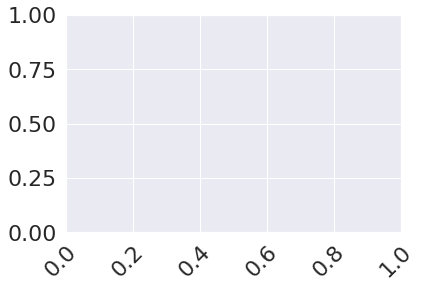

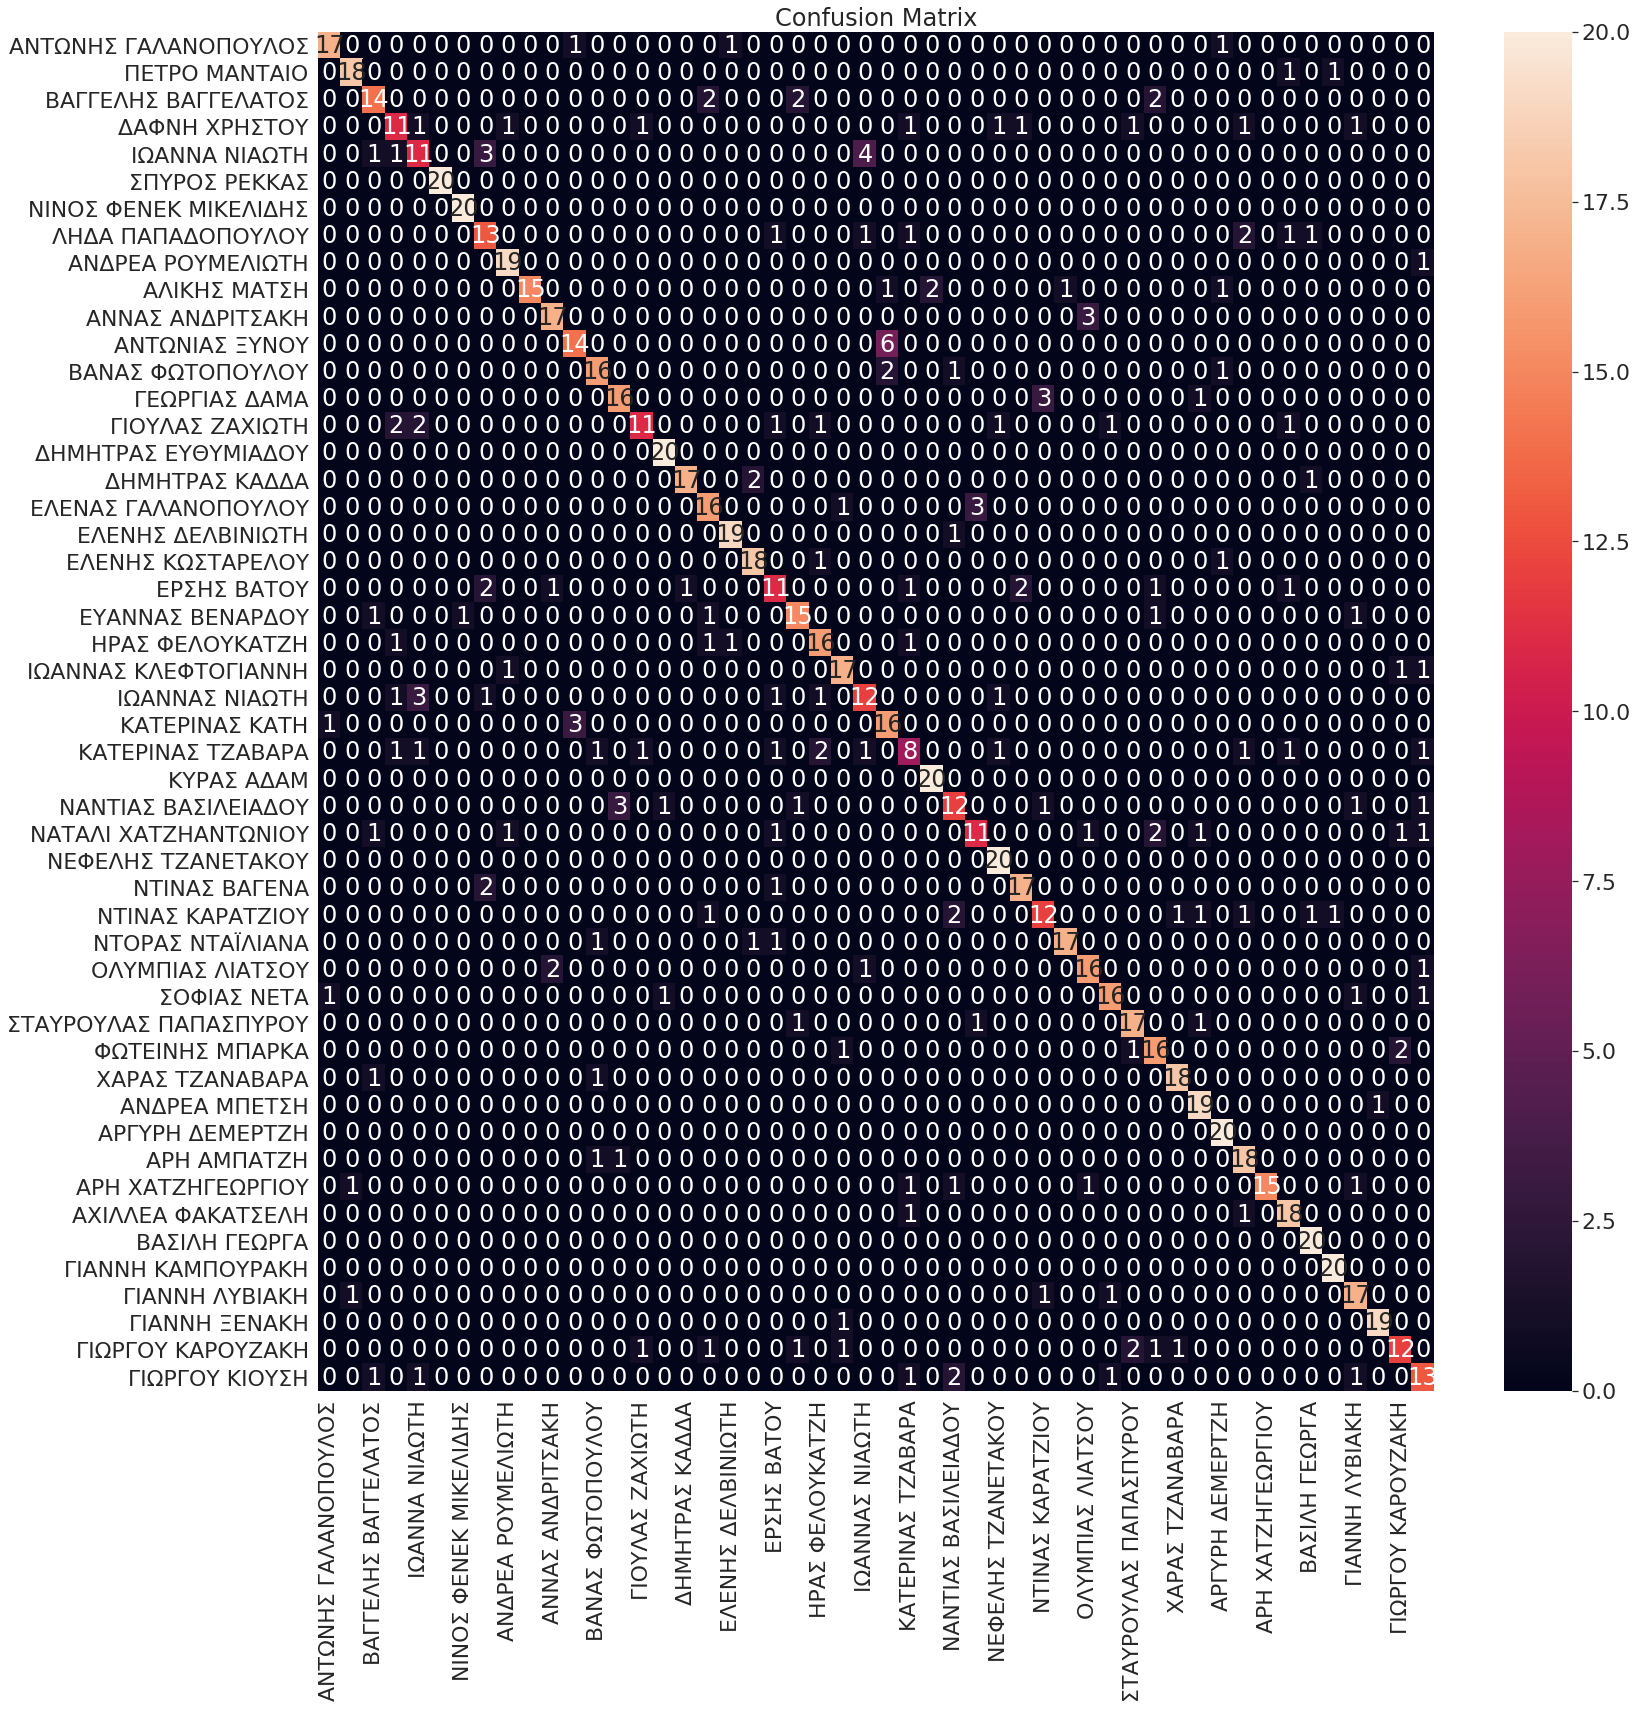

In [22]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


sns.set(font_scale=2)
array = np.array(cm)
df = pd.DataFrame(array, index = [i for i in authorsNames], columns = [i for i in authorsNames])
fig, ax = plt.subplots()
plt.figure(figsize = (25,25))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.title('Confusion Matrix')
sns.heatmap(df, annot = True)

plt.savefig('/content/drive/My Drive/saved_files/paper/images/RNN_WITH_DROPOUT_{}.png'.format(f))

In [ ]:
'''
%matplotlib inline
import json
 
with open('/content/drive/My Drive/saved_files/paper/Test/NewTexts.json') as f:
    te = json.load(f)

myauthors = [x['author'] for x in te]
mytexts = [x['article'] for x in te]

### Give our texts and see the results

def nlargestIndex(mylist, n):
  p = list(range(0,len(mylist)))
  s = sorted(zip(mylist, p), reverse=True)
  l = []
  for i in range(0,n):
    l.append(s[i][1])
  return l

model = r2
x = []
for text in mytexts:
  x.append(create_input(text, vocabulary)) 
y = list(range(0,len(texts)))
dev_x = torch.LongTensor(x).to(device)
dev_y = torch.LongTensor(y).to(device)
y, l     = model(x=dev_x, t=dev_y)


for item, person in zip(y, myauthors): 
  print('for {} predicted in descending order:'.format(person))
  a = item.tolist()
  ans = nlargestIndex(a, 3)
  for i in ans:
    print(authorsNames[i])
  print('------------------')
'''